# Midterm 1 Assignment

#### Various Imports

In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Convolution Method

In [108]:
def img_filter_convolution(image, filter):
    img_shape = image.shape
    filter_size = filter.shape[0]
    filtered_img_shape = tuple((lambda x: x - filter_size + 1)(x) for x in img_shape)
    filtered_img = np.zeros(filtered_img_shape, dtype = int)
    print(filter_size, filtered_img_shape)
    for x in range(filtered_img_shape[0]):
        for y in range(filtered_img_shape[1]):
            filtered_img[x, y] = (image[x:x+filter_size, y:y+filter_size] * filter).sum()
    return filtered_img

### LoG Filter Implementation

In [109]:
def LoG(sigma):
    pass

In [142]:
image = cv2.imread("/home/davide/uni/ISPR-Midterms/Midterm1/MSRC_ObjCategImageDatabase_v1/3_23_s.bmp")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray.shape

(213, 320)

In [147]:
filter = np.zeros((3,3), dtype=int)
filter [0, 0:] = 1
filter [2, 0:] = -1
filter

array([[ 1,  1,  1],
       [ 0,  0,  0],
       [-1, -1, -1]])

In [148]:
output = img_filter_convolution(gray, filter)
output.shape

3 (211, 318)


(211, 318)

<function matplotlib.pyplot.show(close=None, block=None)>

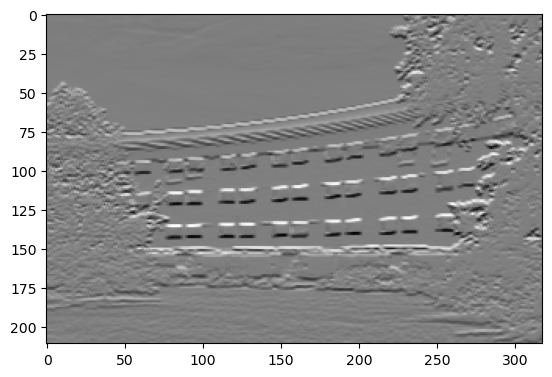

In [149]:
plt.imshow(output, cmap="gray")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

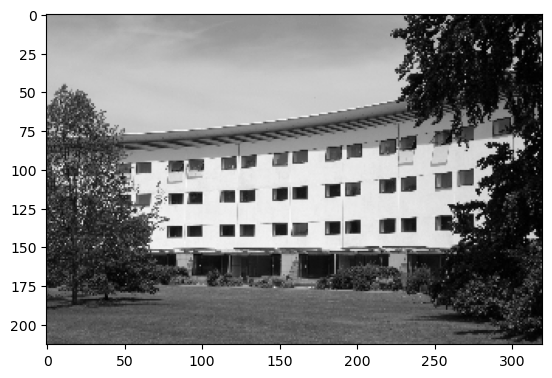

In [150]:
plt.imshow(gray, cmap="gray")
plt.show